### Get uncorrected bigwigs

In [1]:
import pyBigWig
import pandas as pd
import numpy as np

uncorrected_bigwig = "shifted.sorted.bam.bpnet.unstranded.bw"

uncorretced_bw = pyBigWig.open(uncorrected_bigwig)

spi1_bed = "tfm_matches.bed"
spi1_peaks = pd.read_csv(spi1_bed, delimiter="\t", names=[
        "chrom", "start", "end", "key", "strand", "peak_index",
        "imp_total_signed_score", "imp_total_score", "imp_frac_score",
        "imp_ic_avg_score", "agg_sim", "mod_delta", "mod_precision",
        "mod_percentile", "fann_perclasssum_perc", "fann_perclassavg_perc"
    ])
spi1_peaks = spi1_peaks.sort_values(by=['imp_total_score'],ascending = False)
spi1_peaks = spi1_peaks.loc[spi1_peaks['key'] == "0_2"].loc[spi1_peaks['strand'] == "+"]
print(spi1_peaks.shape)
#spi1_peaks = spi1_peaks.tail(500)
#spi1_peaks = spi1_peaks.sample(500)



(9701, 16)


In [2]:
def fetch_footprint_from_bigwig(bed_file,bw):
    foot_prints = []
    for i in range(bed_file.shape[0]):
        start = int(bed_file.iloc[i,1])
        summit = (int(bed_file.iloc[i,1])+int(bed_file.iloc[i,2]))//2 
        flank=150
        total_bw = bw.values(bed_file.iloc[i,0], summit-500, summit+500)
        total_bw = total_bw/np.sum(total_bw)
        foot_prints.append(total_bw[500-flank:500+flank])
    
    foot_prints = np.array(foot_prints)
    return np.mean(foot_prints, axis=0)
    
    
    

In [3]:
uncorrected_footprints = fetch_footprint_from_bigwig(spi1_peaks,uncorretced_bw)

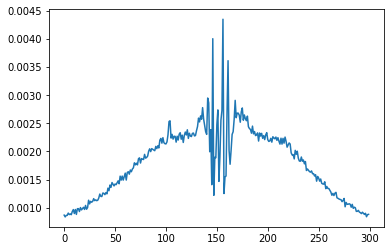

In [4]:
import matplotlib.pyplot as plt
plt.plot(uncorrected_footprints)




In [5]:
from load_model import *
import os
import pyfaidx

os.environ["CUDA_VISIBLE_DEVICES"]="5"
corrected_model=load_model_wrapper(model_hdf5="model.0.hdf5")
reference_genome_path="/mnt/data/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
reader = pyfaidx.Fasta(reference_genome_path)

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 2114, 4)]    0                                            
__________________________________________________________________________________________________
1st_conv (Conv1D)               (None, 2094, 500)    42500       sequence[0][0]                   
__________________________________________________________________________________________________
0_non_dil-crop_1th_dconv (Cropp (None, 2090, 500)    0           1st_conv[0][0]                   
__________________________________________________________________________________________________
1_dilconv (Conv1D)              (None, 2090, 500)    750500      1st_conv[0][0]                   
_______________________________________________________________________________________

In [6]:

def one_hot_encode(seqs):
    """
    Converts a list of DNA ("ACGT") sequences to one-hot encodings, where the
    position of 1s is ordered alphabetically by "ACGT". `seqs` must be a list
    of N strings, where every string is the same length L. Returns an N x L x 4
    NumPy array of one-hot encodings, in the same order as the input sequences.
    All bases will be converted to upper-case prior to performing the encoding.
    Any bases that are not "ACGT" will be given an encoding of all 0s.
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)

    # Join all sequences together into one long string, all uppercase
    seq_concat = "".join(seqs).upper()

    one_hot_map = np.identity(5)[:, :-1]

    # Convert string into array of ASCII character codes;
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)

    # Anything that's not an A, C, G, or T gets assigned a higher code
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85

    # Convert the codes into indices in [0, 4], in ascending order by code
    _, base_inds = np.unique(base_vals, return_inverse=True)

    # Get the one-hot encoding for those indices, and reshape back to separate
    return one_hot_map[base_inds].reshape((len(seqs), seq_len, 4))


In [7]:
def fetch_footprint_from_model(bed_file,model):
    foot_prints = []
    total_data = []
    for i in range(bed_file.shape[0]):
        start = int(bed_file.iloc[i,1])
        summit = (int(bed_file.iloc[i,1])+int(bed_file.iloc[i,2]))//2 
        flank=1057
        flank_tf=150
        seq = reader[bed_file.iloc[i,0]][summit-flank:summit+flank].seq
        one_hot_seq = one_hot_encode(seq)
        input_tensor = np.squeeze(one_hot_seq)
        total_data.append(input_tensor)
        
    batch_size=25
    for i in range(batch_size,len(total_data),batch_size):
        input_tensor = tf.convert_to_tensor(np.array(total_data[i-batch_size:i]))
        predictions = model(input_tensor)
        #prof_preds = softmax(predictions[0].eval(session=get_session()))*np.exp(np.expand_dims(predictions[1].eval(session=get_session()), axis=1))
        prof_preds = softmax(predictions[0].eval(session=get_session()))
        foot_prints.extend(prof_preds[:,500-flank_tf:500+flank_tf,0])
        
    foot_prints = np.array(foot_prints)
    return np.mean(foot_prints, axis=0), foot_prints


[<matplotlib.lines.Line2D at 0x7f28a817fe10>]

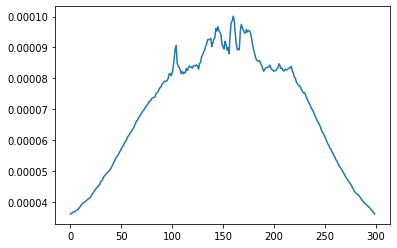

In [8]:
corrected_footprints, corrected_footprints_arr = fetch_footprint_from_model(spi1_peaks,corrected_model)
import matplotlib.pyplot as plt
plt.plot(corrected_footprints)





In [9]:
uncorrected_model=load_model_wrapper(json_string="uncorrected/model.0.arch", weights="uncorrected/model.0.weights")


/users/anusri/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning:  is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [10]:
uncorrected_model_footprints, uncorrected_model_footprints_arr = fetch_footprint_from_model(spi1_peaks,uncorrected_model)


[<matplotlib.lines.Line2D at 0x7f24b7da9090>]

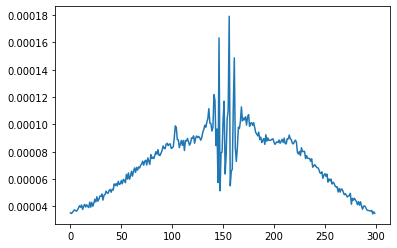

In [11]:
import matplotlib.pyplot as plt
plt.plot(uncorrected_model_footprints)

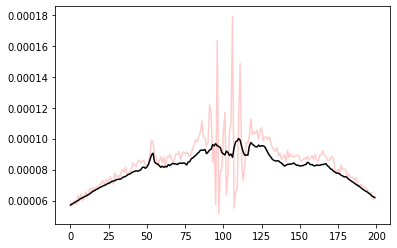

In [12]:
plt.figure()
plt.plot(uncorrected_model_footprints[50:250], color="r", alpha=0.2, label="invivo uncorrected")
plt.plot(corrected_footprints[50:250], color="k", label="invivo corrected")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

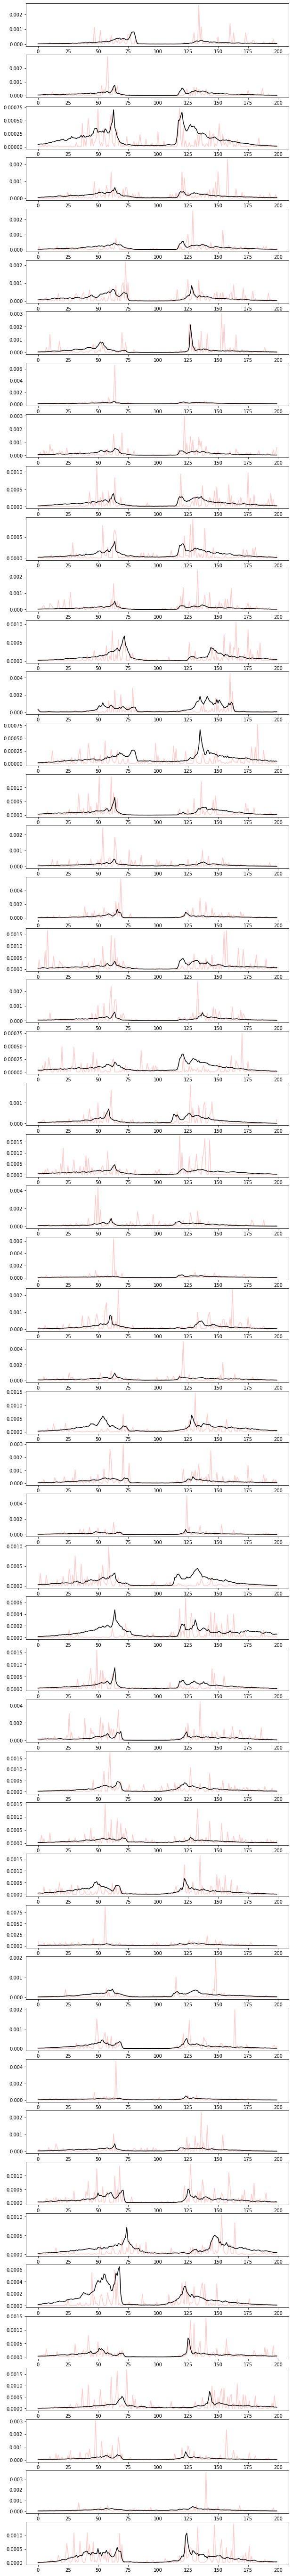

In [14]:
nums=50
plt.rcParams["figure.figsize"] = (10,2*nums)

fig, axs = plt.subplots(nums)
for i in range(nums):
    axs[i].plot(uncorrected_model_footprints_arr[i,50:250], color="r", alpha=0.2, label="invivo uncorrected")
    axs[i].plot(corrected_footprints_arr[i,50:250], color="k", label="invivo corrected")
    
plt.show()

14


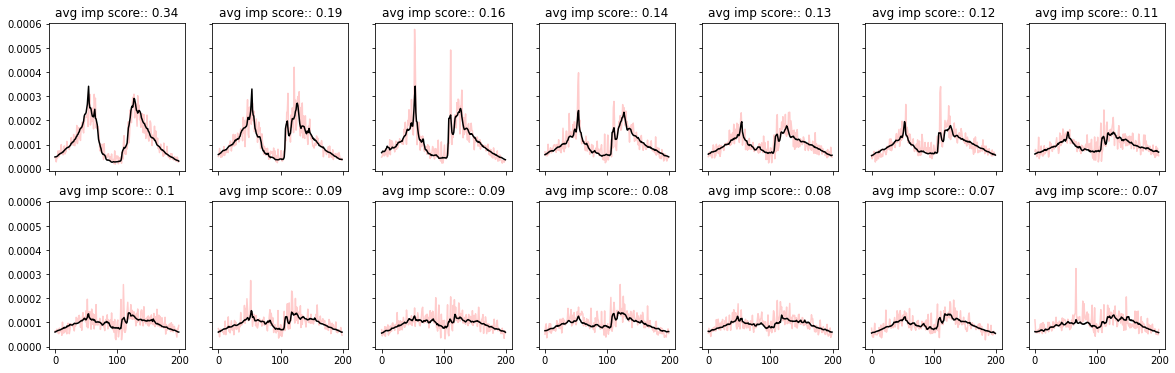

In [39]:
nums=1400
plt.rcParams["figure.figsize"] = (20,6)
fig, axs = plt.subplots(2,7, sharex=True, sharey=True)
plot_vals_uncorrected = []
plot_vals_corrected = []
titles=[]
step=100
for i in range(0,nums, step):
    #print(i)
    plot_vals_uncorrected.append(np.mean(uncorrected_model_footprints_arr[i:i+step,], axis=0)[50:250])
    plot_vals_corrected.append(np.mean(corrected_footprints_arr[i:i+step,], axis=0)[50:250])
    titles.append(np.mean(list(spi1_peaks["imp_total_score"][i:i+step])))

print(len(plot_vals_uncorrected))
for i in range(7):
    axs[0,i].plot(plot_vals_uncorrected[i], color="r", alpha=0.2, label="invivo uncorrected")
    axs[0,i].plot(plot_vals_corrected[i], color="k", label="invivo corrected")
    axs[0,i].set_title("avg imp score:: "+str(round(titles[i],2)))

for i in range(7):
    axs[1,i].plot(plot_vals_uncorrected[7+i], color="r", alpha=0.2, label="invivo uncorrected")
    axs[1,i].plot(plot_vals_corrected[7+i], color="k", label="invivo corrected")
    axs[1,i].set_title("avg imp score:: "+str(round(titles[7+i],2)))


plt.show()

In [ ]:
def get_seq(genome, peaks_df, width=2000):
    vals = []
    for i, r in peaks_df.iterrows():
        vals.append(str(reader[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)]))
        
    return one_hot.dna_to_one_hot(vals)